# Funnel Analysis

The goal is to perform funnel analysis for an e-commerce website.
Typically, websites have a clear path to conversion: for instance, you land on the home page,
then you search, select a product, and buy it. At each of these steps, some users will drop off
and leave the site. The sequence of pages that lead to conversion is called 'funnel'.
Data Science can have a tremendous impact on funnel optimization. Funnel analysis allows to
understand where/when our users abandon the website. It gives crucial insights on user
behavior and on ways to improve the user experience. Also, it often allows to discover bugs.

## Challenge Description
You are looking at data from an e-commerce website. The site is very simple and has just 4
pages:
* The first page is the home page. When you come to the site for the first time, you can only land on the home page as a first page.
* From the home page, the user can perform a search and land on the search page.
* From the search page, if the user clicks on a product, she will get to the payment page, where she is asked to provide payment information in order to buy that product.
* If she does decide to buy, she ends up on the confirmation page

The company CEO isn't very happy with the volume of sales and, especially, of sales coming
from new users. Therefore, she asked you to investigate whether there is something wrong in
the conversion funnel or, in general, if you could suggest how conversion rate can be improved.
Specifically, she is interested in:

* A full picture of funnel conversion rate for both desktop and mobile
* Some insights on what the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve conversion rate.

## Solution - Revisit this

* The cohort analysis 
* Device/gender analysis to check other abnormalities

It looks like the mobile platform's home_to_search CTR is actually changing a lot from Jan-Feb to March-April. However, Desktop environment's search to pay conversion (CTR) is falling from 18% to 4-5%s from Jan-Feb to March-April. Eventhough, desktop payment confirmation is slightly lower than the mobile, I would not necessarily but this as the primary reason. 
The priorities for search_to_pay drop should be checked in:
    
    1- Desktop search & payment pages.
    2- Mobile home & search would be a good thing to check as well as there is a significant drop from Jan-Feb to MArch-April. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.stats import chi2_contingency

%matplotlib inline
plt.style.use('ggplot')

In [2]:
user_info = pd.read_csv('user_table.csv')
home_page = pd.read_csv('home_page_table.csv')
search_page = pd.read_csv('search_page_table.csv')
payment_page = pd.read_csv('payment_page_table.csv')
confirmation_page = pd.read_csv('payment_confirmation_table.csv')

In [3]:
df_list = [user_info, home_page, search_page, payment_page, confirmation_page]
for df in df_list:
    print df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 4 columns):
user_id    90400 non-null int64
date       90400 non-null object
device     90400 non-null object
sex        90400 non-null object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 2 columns):
user_id    90400 non-null int64
page       90400 non-null object
dtypes: int64(1), object(1)
memory usage: 1.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45200 entries, 0 to 45199
Data columns (total 2 columns):
user_id    45200 non-null int64
page       45200 non-null object
dtypes: int64(1), object(1)
memory usage: 706.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6030 entries, 0 to 6029
Data columns (total 2 columns):
user_id    6030 non-null int64
page       6030 non-null object
dtypes: int64(1), object(1)
memory usage: 94.3+ KB
None
<class 'pandas.core.fra

All the df's are looking similar, except user information. It is a good practice to convert the datetime objects into datetime objects. 

In [4]:
user_info['date']=pd.to_datetime(user_info['date'], format='%Y-%m-%d')
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 4 columns):
user_id    90400 non-null int64
date       90400 non-null datetime64[ns]
device     90400 non-null object
sex        90400 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.8+ MB


In [5]:
user_info.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [6]:
df_page_list = [home_page, search_page, payment_page, confirmation_page]
for i, dataframe in enumerate(df_page_list):
    print str(i), dataframe.page.value_counts()
    print str(i), dataframe.page.unique()
    print str(i), dataframe.page.isnull().count()
    print str(i), "lenght", len(dataframe)
    print str(i), "no dublicate lenght", len(dataframe.drop_duplicates())
    print 

0 home_page    90400
Name: page, dtype: int64
0 ['home_page']
0 90400
0 lenght 90400
0 no dublicate lenght 90400

1 search_page    45200
Name: page, dtype: int64
1 ['search_page']
1 45200
1 lenght 45200
1 no dublicate lenght 45200

2 payment_page    6030
Name: page, dtype: int64
2 ['payment_page']
2 6030
2 lenght 6030
2 no dublicate lenght 6030

3 payment_confirmation_page    452
Name: page, dtype: int64
3 ['payment_confirmation_page']
3 452
3 lenght 452
3 no dublicate lenght 452



The above check confirms that all the pages have the right info, and there is no null values, nor any dublicated. This means we can actually merge them into 1 single df all together. 

In [7]:
funnel_df = pd.concat(df_page_list)
funnel_df.head()

,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [8]:
funnel_df.page.value_counts()

home_page                    90400
search_page                  45200
payment_page                  6030
payment_confirmation_page      452
Name: page, dtype: int64

Let's make a plot for comparing these with each other for the entire dataframe before we dig into the cohort analysis. 

In [9]:
funnel_df['page'].replace({'home_page':'home', 'search_page':'search', 'payment_page':'payment', \
                           'payment_confirmation_page':'confirmation'}, inplace = True)

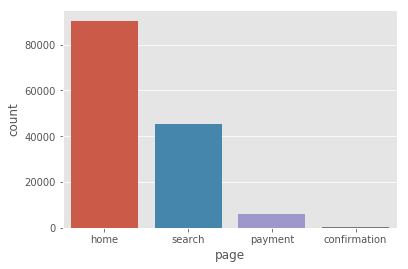

In [10]:
sns.countplot(data = funnel_df, x='page', \
              order=['home', 'search', 'payment', 'confirmation'])
plt.show()

Let's calculate the conversions from one page to another:

In [11]:
home = funnel_df.page.value_counts()[0]
search = funnel_df.page.value_counts()[1]
payment = funnel_df.page.value_counts()[2]
confirmation = funnel_df.page.value_counts()[3]

In [12]:
home_to_search_conv = 1/float(home/search)*100
search_to_payment_conv = 1/float(search/payment)*100
payment_to_confirmation = 1/float(payment/confirmation)*100
print "home_to_search %", home_to_search_conv
print "search_to_payment %", search_to_payment_conv
print "payment_to_confirmation %", payment_to_confirmation

home_to_search % 50.0
search_to_payment % 14.2857142857
payment_to_confirmation % 7.69230769231


This means half of the people who gets to the home page are searching smt, and only 14 % of those who searched smt are actually clicking on items to purchase, and of those who clicked on the purchasing page only 7.7 % are completing the payment. 

This was the overall dataset. Now, we can start investigating the cohort analysis as the CEO was requesting. 

### Cohort Analysis

In [13]:
user_info.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [14]:
user_info.device.unique()

array(['Desktop', 'Mobile'], dtype=object)

In [15]:
user_info.date.unique()

array(['2015-02-28T00:00:00.000000000', '2015-01-13T00:00:00.000000000',
       '2015-04-09T00:00:00.000000000', '2015-02-18T00:00:00.000000000',
       '2015-01-15T00:00:00.000000000', '2015-03-03T00:00:00.000000000',
       '2015-04-15T00:00:00.000000000', '2015-01-27T00:00:00.000000000',
       '2015-04-12T00:00:00.000000000', '2015-02-24T00:00:00.000000000',
       '2015-04-13T00:00:00.000000000', '2015-02-13T00:00:00.000000000',
       '2015-03-14T00:00:00.000000000', '2015-04-02T00:00:00.000000000',
       '2015-04-25T00:00:00.000000000', '2015-02-27T00:00:00.000000000',
       '2015-02-11T00:00:00.000000000', '2015-04-11T00:00:00.000000000',
       '2015-01-25T00:00:00.000000000', '2015-03-19T00:00:00.000000000',
       '2015-03-11T00:00:00.000000000', '2015-04-14T00:00:00.000000000',
       '2015-01-21T00:00:00.000000000', '2015-04-03T00:00:00.000000000',
       '2015-01-30T00:00:00.000000000', '2015-03-25T00:00:00.000000000',
       '2015-04-19T00:00:00.000000000', '2015-03-08

Let's reduce this to smaller groups

In [16]:
print user_info.date.max(), user_info.date.min()

2015-04-30 00:00:00 2015-01-01 00:00:00


In [17]:
user_info.date = user_info.date.apply(lambda x: x.strftime('%m'))
user_info.date.unique()

array(['02', '01', '04', '03'], dtype=object)

4 Cohorts, good number to start with... 

In [18]:
df = pd.merge(funnel_df, user_info, how="inner", on='user_id')
df.head()

,user_id,page,date,device,sex
0,313593,home,02,Desktop,Female
1,468315,home,02,Desktop,Male
2,264005,home,03,Desktop,Female
3,290784,home,03,Desktop,Male
4,639104,home,01,Desktop,Female


In [19]:
df.page.value_counts()

home            90400
search          45200
payment          6030
confirmation      452
Name: page, dtype: int64

In [20]:
df.device.value_counts()

Desktop    93460
Mobile     48622
Name: device, dtype: int64

In [21]:
df.date.value_counts()

02    38872
01    38733
04    32323
03    32154
Name: date, dtype: int64

Let's see how the page visits are changing from one cohort to another.

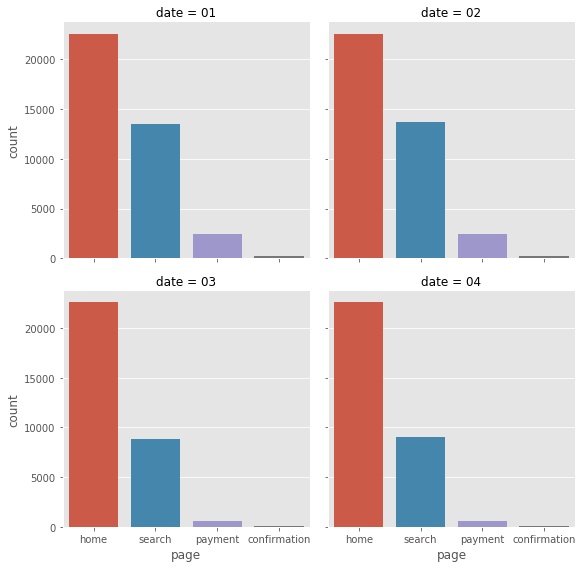

In [22]:
sns.factorplot(data = df, x = 'page', order = ['home', 'search', 'payment','confirmation'],\
               kind = 'count', col = 'date', col_wrap = 2)
plt.show()

In [23]:
grouped_df = df.groupby(['date', 'page'], as_index=False).count()[['date', 'page', 'user_id']]
# as_index=False is the key here, otherwise you cannot split the data, or I mean is the grouped columns
grouped_df

,date,page,user_id
0,01,confirmation,189
1,01,home,22600
2,01,payment,2390
3,01,search,13554
4,02,confirmation,173
5,02,home,22600
6,02,payment,2412
7,02,search,13687
8,03,confirmation,44
9,03,home,22600


In [24]:
pivotted_table = grouped_df.pivot_table(index = ['date'], columns='page', values='user_id')
pivotted_table

page,confirmation,home,payment,search
date,,,,
01,189,22600,2390,13554
02,173,22600,2412,13687
03,44,22600,631,8879
04,46,22600,597,9080


Now that the df is reciprocated, I can include the conversion rates for all the cohorts.

In [25]:
pivotted_table['home_to_search_conv'] = pivotted_table['search'].divide(pivotted_table['home'])*100
pivotted_table['search_to_payment_conv'] = pivotted_table['payment'].divide(pivotted_table['search'])*100
pivotted_table['payment_to_confirmation'] = pivotted_table['confirmation'].divide(pivotted_table['payment'])*100
pivotted_table

page,confirmation,home,payment,search,home_to_search_conv,search_to_payment_conv,payment_to_confirmation
date,,,,,,,
01,189,22600,2390,13554,59.973451,17.633171,7.907950
02,173,22600,2412,13687,60.561947,17.622562,7.172471
03,44,22600,631,8879,39.287611,7.106656,6.973059
04,46,22600,597,9080,40.176991,6.574890,7.705193


We can see the clear difference between cohorts in the conversion rates. The main difference is from home_to_search conversion, and search_to_payment conversion. 

In [26]:
conversions = pd.melt(pivotted_table.reset_index()[['date', 'home_to_search_conv','search_to_payment_conv',\
                                                    'payment_to_confirmation']], id_vars = ['date'], var_name='page',\
                      value_name='conversion')
conversions

,date,page,conversion
0,01,home_to_search_conv,59.973451
1,02,home_to_search_conv,60.561947
2,03,home_to_search_conv,39.287611
3,04,home_to_search_conv,40.176991
4,01,search_to_payment_conv,17.633171
5,02,search_to_payment_conv,17.622562
6,03,search_to_payment_conv,7.106656
7,04,search_to_payment_conv,6.574890
8,01,payment_to_confirmation,7.907950
9,02,payment_to_confirmation,7.172471


In [27]:
conversions['page'].replace({'home_to_search_conv':'home_to_search', \
                           'search_to_payment_conv':'search_to_pay', \
                           'payment_to_confirmation':'pay_to_confrm'}, inplace = True)

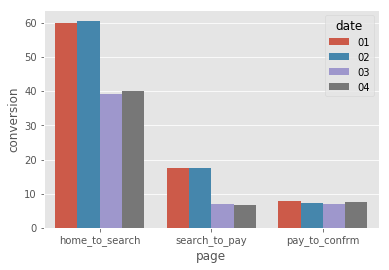

In [28]:
sns.barplot(data = conversions, x = 'page', y = 'conversion',
            hue = 'date')
plt.show()

These are the ratios, not the numbers. Even the ratios of the conversions are changing between Jan-Feb group to March-April group. Let's try to dig deeper from the other aspects as gender and device. 

In [29]:
df.head()

,user_id,page,date,device,sex
0,313593,home,02,Desktop,Female
1,468315,home,02,Desktop,Male
2,264005,home,03,Desktop,Female
3,290784,home,03,Desktop,Male
4,639104,home,01,Desktop,Female


In [30]:
df.sex.value_counts()

Female    71092
Male      70990
Name: sex, dtype: int64

In [31]:
len(df)

142082

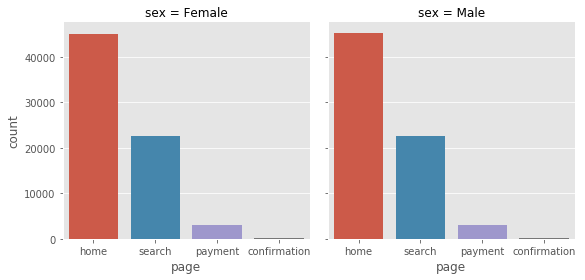

In [32]:
sns.factorplot(data = df, x = 'page', order = ['home', 'search', 'payment','confirmation'],\
               kind = 'count', col = 'sex', col_wrap = 2)
plt.show()

In [33]:
rank = df.shape[0] - df.isnull().sum()
rank

user_id    142082
page       142082
date       142082
device     142082
sex        142082
dtype: int64

In [34]:
df.groupby('sex').head()

,user_id,page,date,device,sex
0,313593,home,02,Desktop,Female
1,468315,home,02,Desktop,Male
2,264005,home,03,Desktop,Female
3,290784,home,03,Desktop,Male
4,639104,home,01,Desktop,Female
5,639104,search,01,Desktop,Female
6,262889,home,01,Mobile,Male
7,708793,home,04,Mobile,Female
8,943143,home,04,Desktop,Male
9,943143,search,04,Desktop,Male


In [35]:
grouped_by_gender = df.groupby(['sex', 'page'], as_index=False).count()[[ 'sex', 'page', 'user_id']]
pivotted_by_gender = grouped_by_gender.pivot_table(index=['sex'], columns='page', values='user_id')
pivotted_by_gender

page,confirmation,home,payment,search
sex,,,,
Female,241,45075,3100,22676
Male,211,45325,2930,22524


In [36]:
pivotted_by_gender.T

sex,Female,Male
page,,
confirmation,241,211
home,45075,45325
payment,3100,2930
search,22676,22524


In [37]:
p = chi2_contingency(pivotted_by_gender.T)[1]
p 

0.04784105593081749

Since p ~ 0.047 which is smaller than 0.05, this tells us genders are not behaving differently in the bulk group. However, they might be with the cohort analysis.

In [38]:
grouped_by_sex = df.groupby(['date', 'sex', 'page'], as_index=False).count()[['date', 'sex', 'page', 'user_id']]
pivotted_by_sex = grouped_by_sex.pivot_table(index=['date', 'sex'], columns='page', values='user_id')
pivotted_by_sex

page         confirmation   home  payment  search
date sex                                         
01   Female           109  11414     1243    6913
     Male              80  11186     1147    6641
02   Female            86  11199     1235    6820
     Male              87  11401     1177    6867
03   Female            26  11250      337    4454
     Male              18  11350      294    4425
04   Female            20  11212      285    4489
     Male              26  11388      312    4591

In [39]:
pivotted_by_sex['home_to_search_conv'] = pivotted_by_sex['search'].divide(pivotted_by_sex['home'])*100
pivotted_by_sex['search_to_payment_conv'] = pivotted_by_sex['payment'].divide(pivotted_by_sex['search'])*100
pivotted_by_sex['payment_to_confirmation'] = pivotted_by_sex['confirmation'].divide(pivotted_by_sex['payment'])*100
pivotted_by_sex

page         confirmation   home  payment  search  home_to_search_conv  \
date sex                                                                 
01   Female           109  11414     1243    6913            60.565972   
     Male              80  11186     1147    6641            59.368854   
02   Female            86  11199     1235    6820            60.898294   
     Male              87  11401     1177    6867            60.231559   
03   Female            26  11250      337    4454            39.591111   
     Male              18  11350      294    4425            38.986784   
04   Female            20  11212      285    4489            40.037460   
     Male              26  11388      312    4591            40.314366   

page         search_to_payment_conv  payment_to_confirmation  
date sex                                                      
01   Female               17.980616                 8.769107  
     Male                 17.271495                 6.974717  
02   Female               18.108504                 6.963563  
     Male                 17.139945                 7.391674  
03   Female                7.566233                 7.715134  
     Male                  6.644068                 6.122449  
04   Female                6.348853                 7.017544  
     Male                  6.795905                 8.333333

In [40]:
conversions_by_sex = pd.melt(pivotted_by_sex.reset_index()[['date', 'sex', 'home_to_search_conv','search_to_payment_conv',\
                                                    'payment_to_confirmation']], id_vars = ['date', 'sex'], var_name='page',\
                      value_name='conversion')
conversions_by_sex

,date,sex,page,conversion
0,01,Female,home_to_search_conv,60.565972
1,01,Male,home_to_search_conv,59.368854
2,02,Female,home_to_search_conv,60.898294
3,02,Male,home_to_search_conv,60.231559
4,03,Female,home_to_search_conv,39.591111
5,03,Male,home_to_search_conv,38.986784
6,04,Female,home_to_search_conv,40.037460
7,04,Male,home_to_search_conv,40.314366
8,01,Female,search_to_payment_conv,17.980616
9,01,Male,search_to_payment_conv,17.271495


In [41]:
conversions_by_sex['page'].replace({'home_to_search_conv':'home_to_search', \
                           'search_to_payment_conv':'search_to_pay', \
                           'payment_to_confirmation':'pay_to_confrm'}, inplace = True)

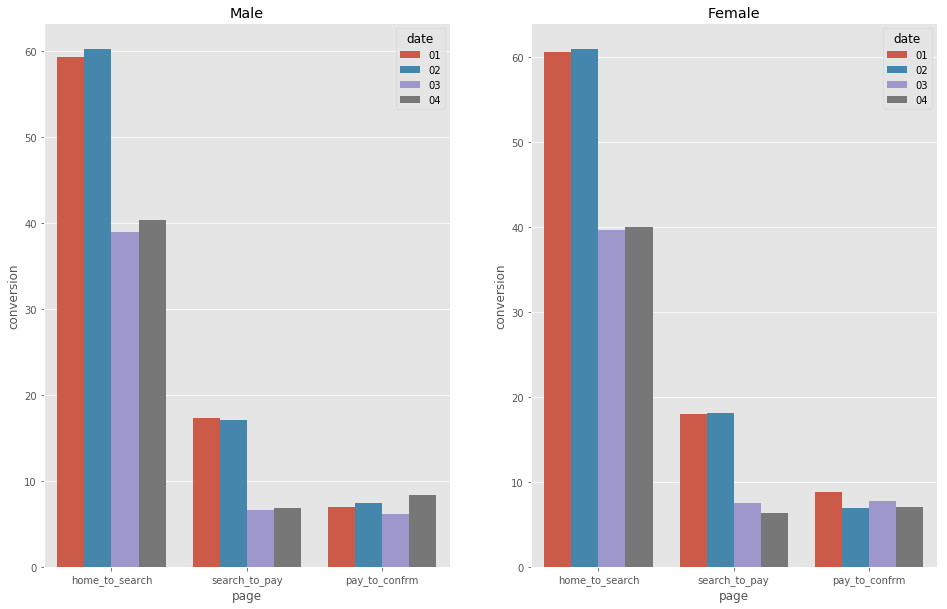

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,10))

sns.barplot(data = conversions_by_sex[conversions_by_sex['sex'] == 'Male'], x = 'page', y = 'conversion', \
            hue = 'date', ax=ax1)
ax1.set_title('Male')

sns.barplot(data = conversions_by_sex[conversions_by_sex['sex'] == 'Female'], x = 'page', y = 'conversion', \
            hue = 'date', ax=ax2)
ax2.set_title('Female')

plt.show()

It looks like Males are confirming the purchase more than females, however it is not a big difference. We can check the difference between two groups later.

In [43]:
df.device.value_counts()

Desktop    93460
Mobile     48622
Name: device, dtype: int64

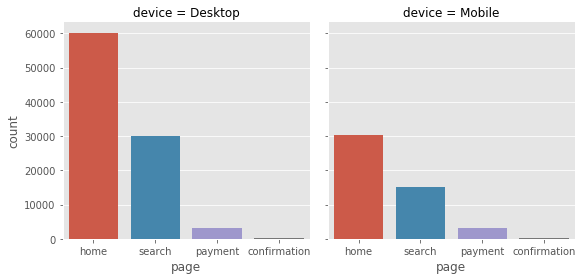

In [44]:
sns.factorplot(data = df, x = 'page', order = ['home', 'search', 'payment','confirmation'],\
               kind = 'count', col = 'device', col_wrap = 2)
plt.show()

In [45]:
grouped_by_device = df.groupby(['date', 'device', 'page'], as_index=False).count()[['date', 'device', \
                                                                                    'page', 'user_id']]
pivotted_by_device = grouped_by_device.pivot_table(index=['date', 'device'], columns='page', values='user_id')
pivotted_by_device

page          confirmation   home  payment  search
date device                                       
01   Desktop            60  15050     1221    7529
     Mobile            129   7550     1169    6025
02   Desktop            54  15050     1191    7632
     Mobile            119   7550     1221    6055
03   Desktop            14  15050      296    7370
     Mobile             30   7550      335    1509
04   Desktop            22  15050      302    7569
     Mobile             24   7550      295    1511

In [46]:
pivotted_by_device['home_to_search_conv'] = pivotted_by_device['search'].divide(pivotted_by_device['home'])*100
pivotted_by_device['search_to_payment_conv'] = pivotted_by_device['payment'].divide(pivotted_by_device['search'])*100
pivotted_by_device['payment_to_confirmation'] = pivotted_by_device['confirmation'].divide(pivotted_by_device['payment'])*100
pivotted_by_device

page          confirmation   home  payment  search  home_to_search_conv  \
date device                                                               
01   Desktop            60  15050     1221    7529            50.026578   
     Mobile            129   7550     1169    6025            79.801325   
02   Desktop            54  15050     1191    7632            50.710963   
     Mobile            119   7550     1221    6055            80.198675   
03   Desktop            14  15050      296    7370            48.970100   
     Mobile             30   7550      335    1509            19.986755   
04   Desktop            22  15050      302    7569            50.292359   
     Mobile             24   7550      295    1511            20.013245   

page          search_to_payment_conv  payment_to_confirmation  
date device                                                    
01   Desktop               16.217293                 4.914005  
     Mobile                19.402490                11.035073  
02   Desktop               15.605346                 4.534005  
     Mobile                20.165153                 9.746110  
03   Desktop                4.016282                 4.729730  
     Mobile                22.200133                 8.955224  
04   Desktop                3.989959                 7.284768  
     Mobile                19.523494                 8.135593

In [47]:
conversions_by_device = pd.melt(pivotted_by_device.reset_index()[['date', 'device', 'home_to_search_conv',\
                                                                  'search_to_payment_conv', 'payment_to_confirmation']], \
                                id_vars = ['date', 'device'], var_name='page', value_name='conversion')
conversions_by_device

,date,device,page,conversion
0,01,Desktop,home_to_search_conv,50.026578
1,01,Mobile,home_to_search_conv,79.801325
2,02,Desktop,home_to_search_conv,50.710963
3,02,Mobile,home_to_search_conv,80.198675
4,03,Desktop,home_to_search_conv,48.970100
5,03,Mobile,home_to_search_conv,19.986755
6,04,Desktop,home_to_search_conv,50.292359
7,04,Mobile,home_to_search_conv,20.013245
8,01,Desktop,search_to_payment_conv,16.217293
9,01,Mobile,search_to_payment_conv,19.402490


In [48]:
conversions_by_device['page'].replace({'home_to_search_conv':'home_to_search', \
                           'search_to_payment_conv':'search_to_pay', \
                           'payment_to_confirmation':'pay_to_confrm'}, inplace = True)

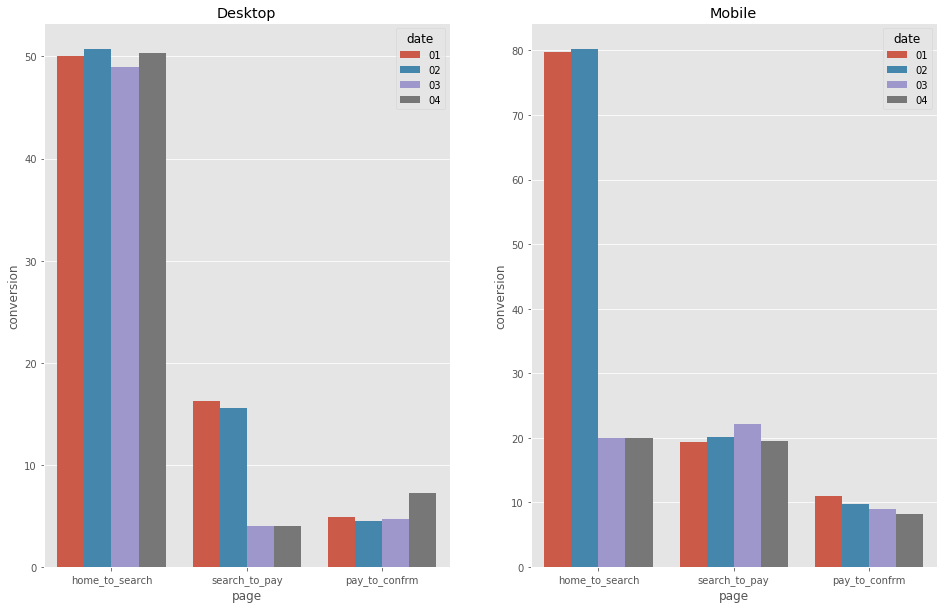

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,10))

sns.barplot(data = conversions_by_device[conversions_by_device['device'] == 'Desktop'], x = 'page', y = 'conversion', \
            hue = 'date', ax=ax1)
ax1.set_title('Desktop')

sns.barplot(data = conversions_by_device[conversions_by_device['device'] == 'Mobile'], x = 'page', y = 'conversion', \
            hue = 'date', ax=ax2)
ax2.set_title('Mobile')

plt.show()

It looks like the mobile platform's home_to_search CTR is actually changing a lot from Jan-Feb to March-April. However, Desktop environment's search to pay conversion (CTR) is falling from 18% to 4-5%s from Jan-Feb to March-April. Eventhough, desktop payment confirmation is slightly lower than the mobile, I would not necessarily but this as the primary reason. 
The priorities for search_to_pay drop should be checked in:
    
    1- Desktop search & payment pages.
    2- Mobile home_to_search would be a good thing to check as well as there is a significant drop from Jan-Feb to MArch-April. 

In [50]:
'''Altered Function 
# Make a function to group and pivot
def group_And_transpose(df, columns, merge_column):
    "GroupBy the data by the columns and summarize it"
    
    # All ids to group by
    grouping = columns + indep_col
    
    # Group by given variables
    grouped = df.groupby(grouping, as_index = False).count()[grouping + merge_column]
    
    # Summarize on the variables
    pivoted_data = grouped.pivot_table(index=columns, columns=indep_col, values=merge_column)
    
    return pivoted_data'''

'Altered Function \n# Make a function to group and pivot\ndef group_And_transpose(df, columns, merge_column):\n    "GroupBy the data by the columns and summarize it"\n    \n    # All ids to group by\n    grouping = columns + indep_col\n    \n    # Group by given variables\n    grouped = df.groupby(grouping, as_index = False).count()[grouping + merge_column]\n    \n    # Summarize on the variables\n    pivoted_data = grouped.pivot_table(index=columns, columns=indep_col, values=merge_column)\n    \n    return pivoted_data'

In [51]:
""" Last Altered function:
def convert(df, col1, col2, col3, col4):
    
    '''Conversions are added as columns to a dataframe'''
    df['1_to_2'] = 100 * df[col2].divide(df[col1])
    df['2_to_3'] = 100 * df[col3].divide(df[col2])
    df['3_to_4'] = 100 * df[col4].divide(df[col3])

    return df

"""

" Last Altered function:\ndef convert(df, col1, col2, col3, col4):\n    \n    '''Conversions are added as columns to a dataframe'''\n    df['1_to_2'] = 100 * df[col2].divide(df[col1])\n    df['2_to_3'] = 100 * df[col3].divide(df[col2])\n    df['3_to_4'] = 100 * df[col4].divide(df[col3])\n\n    return df\n\n"

In [52]:
""" Another Altered function:
def longConvt(df, columns):
    '''Longer version of the pivot table to plot the conversions'''
    plotting_conversions = pd.melt(df.reset_index()[columns + ['1_to_2','2_to_3','3_to_4']],
                               id_vars = columns, var_name = 'indep_col', value_name = 'col4')
    
    return plotting_conversions

"""

" Another Altered function:\ndef longConvt(df, columns):\n    '''Longer version of the pivot table to plot the conversions'''\n    plotting_conversions = pd.melt(df.reset_index()[columns + ['1_to_2','2_to_3','3_to_4']],\n                               id_vars = columns, var_name = 'indep_col', value_name = 'col4')\n    \n    return plotting_conversions\n\n"